<a href="https://colab.research.google.com/github/bedhinesh/capstone-aiml/blob/dhinesh/Capstone_project_Dhinesh_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 
## Domain : Automotive, Surveillance. 
#### **Context** : Computer vision can be used to automate supervision and generate action . Appropriate action trigger is possible if the event is predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of the car, type, colour, number plates etc
## **PROJECT OBJECTIVE**: Design a Deep Learning based car identification model. By given image of a car we should be able to predict which make , model of the car

# DATA DESCRIPTION:
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

1.   Train Images: Consists of real images of cars as per the make and year of the car.
2.   Test Images: Consists of real images of cars as per the make and year of the car.
3.   Train Annotation: Consists of bounding box region for training images.
4.   Test Annotation: Consists of bounding box region for testing images



In [1]:
#Import Libraries
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Initialize the random number generator
import random
random.seed(0)

#Tensor Flow
import tensorflow
tensorflow.__version__

#Matplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

#Importing drive
from google.colab import drive
#OS
import os
#Numpy
import numpy as np
#Pandas
import pandas as pd

#CV2
import cv2

#Image data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
#Mount Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
project_path = '/content/drive/My Drive/kaggle/'
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [4]:
#Download data from kaggle
#!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
#!ls
#unzipping the zip files and deleting the zip files
#!unzip \*.zip

In [83]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file


    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    print(path)
    img = cv2.imread(path, 1)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]

In [5]:
# metadata = load_metadata('images')
trainMetaData = load_metadata('car_data/car_data/train/')
trainMetaData.shape


(8144,)

In [6]:
testMetaData = load_metadata('car_data/car_data/test/')
testMetaData.shape

(8041,)

In [27]:

print(testMetaData[0])
trainMetaDataDF = pd.DataFrame(trainMetaData)
trainMetaDataDF[1]=trainMetaDataDF[0].apply(lambda x: x.image_path().rsplit("/",1)[0])
trainMetaDataDF[2]=trainMetaDataDF[0].apply(lambda x: x.image_path().rsplit("/",1)[1])
print(trainMetaDataDF[0][1])
print(trainMetaDataDF[1][1])
print(trainMetaDataDF[2][1])
testMetaDataDF = pd.DataFrame(testMetaData)
testMetaDataDF[1]=testMetaDataDF[0].apply(lambda x: x.image_path().rsplit("/",1)[0])
testMetaDataDF[2]=testMetaDataDF[0].apply(lambda x: x.image_path().rsplit("/",1)[1])
print(testMetaDataDF[0][1])
print(testMetaDataDF[1][1])
print(testMetaDataDF[2][1])

car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg
car_data/car_data/train/AM General Hummer SUV 2000/06174.jpg
car_data/car_data/train/AM General Hummer SUV 2000
06174.jpg
car_data/car_data/test/AM General Hummer SUV 2000/00457.jpg
car_data/car_data/test/AM General Hummer SUV 2000
00457.jpg


In [28]:
annotation_train_csv = pd.read_csv('anno_train.csv', header = None)
annotation_test_csv = pd.read_csv('anno_test.csv', header = None)
data_labels = np.array(pd.read_csv('names.csv',header = None))


In [29]:
print(annotation_train_csv.info)
print(annotation_test_csv.info)
print(data_labels[10])
annotation_train_csv

<bound method DataFrame.info of               0    1    2     3     4    5
0     00001.jpg   39  116   569   375   14
1     00002.jpg   36  116   868   587    3
2     00003.jpg   85  109   601   381   91
3     00004.jpg  621  393  1484  1096  134
4     00005.jpg   14   36   133    99  106
...         ...  ...  ...   ...   ...  ...
8139  08140.jpg    3   44   423   336   78
8140  08141.jpg  138  150   706   523  196
8141  08142.jpg   26  246   660   449  163
8142  08143.jpg   78  526  1489   908  112
8143  08144.jpg   20  240   862   677   17

[8144 rows x 6 columns]>
<bound method DataFrame.info of               0    1    2     3    4    5
0     00001.jpg   30   52   246  147  181
1     00002.jpg  100   19   576  203  103
2     00003.jpg   51  105   968  659  145
3     00004.jpg   67   84   581  407  187
4     00005.jpg  140  151   593  339  185
...         ...  ...  ...   ...  ...  ...
8036  08037.jpg   49   57  1169  669   63
8037  08038.jpg   23   18   640  459   16
8038  08039.jpg 

0    1    2     3     4    5
0     00001.jpg   39  116   569   375   14
1     00002.jpg   36  116   868   587    3
2     00003.jpg   85  109   601   381   91
3     00004.jpg  621  393  1484  1096  134
4     00005.jpg   14   36   133    99  106
...         ...  ...  ...   ...   ...  ...
8139  08140.jpg    3   44   423   336   78
8140  08141.jpg  138  150   706   523  196
8141  08142.jpg   26  246   660   449  163
8142  08143.jpg   78  526  1489   908  112
8143  08144.jpg   20  240   862   677   17

[8144 rows x 6 columns]

In [80]:
train_data = annotation_train_csv.copy()
test_data = annotation_test_csv.copy()

In [99]:
train_data[6]=data_labels[train_data[5]-1]
train_data[7]=train_data[6].apply(lambda x: x.rsplit(" ",2)[0])
train_data[8]=train_data[6].apply(lambda x: x.rsplit(" ",2)[1])
train_data[9]=train_data[6].apply(lambda x: x.rsplit(" ",2)[2])
pathData = []
for i in train_data[0]:
  pathData.append((trainMetaDataDF.loc[trainMetaDataDF[2] == i][0].values)[0])
train_data[10] = pathData
print(train_data.head)
test_data[6]=data_labels[test_data[5]-1]
test_data[7]=test_data[6].apply(lambda x: x.rsplit(" ",2)[0])
test_data[8]=test_data[6].apply(lambda x: x.rsplit(" ",2)[1])
test_data[9]=test_data[6].apply(lambda x: x.rsplit(" ",2)[2])
pathData = []
for i in test_data[0]:
  pathData.append((testMetaDataDF.loc[testMetaDataDF[2] == i][0].values)[0])
test_data[10] = pathData
print(test_data.head)
train_data

<bound method NDFrame.head of              0    1   ...    9                                                  10
0     00001.jpg   39  ...  2012  car_data/car_data/train/Audi TTS Coupe 2012/00...
1     00002.jpg   36  ...  2012  car_data/car_data/train/Acura TL Sedan 2012/00...
2     00003.jpg   85  ...  2007  car_data/car_data/train/Dodge Dakota Club Cab ...
3     00004.jpg  621  ...  2012  car_data/car_data/train/Hyundai Sonata Hybrid ...
4     00005.jpg   14  ...  2012  car_data/car_data/train/Ford F-450 Super Duty ...
...         ...  ...  ...   ...                                                ...
8139  08140.jpg    3  ...  2012  car_data/car_data/train/Chrysler Town and Coun...
8140  08141.jpg  138  ...  2012  car_data/car_data/train/smart fortwo Convertib...
8141  08142.jpg   26  ...  2009  car_data/car_data/train/Mercedes-Benz SL-Class...
8142  08143.jpg   78  ...  2006  car_data/car_data/train/Ford GT Coupe 2006/081...
8143  08144.jpg   20  ...  1994  car_data/car_data/train/

0    1   ...    9                                                  10
0     00001.jpg   39  ...  2012  car_data/car_data/train/Audi TTS Coupe 2012/00...
1     00002.jpg   36  ...  2012  car_data/car_data/train/Acura TL Sedan 2012/00...
2     00003.jpg   85  ...  2007  car_data/car_data/train/Dodge Dakota Club Cab ...
3     00004.jpg  621  ...  2012  car_data/car_data/train/Hyundai Sonata Hybrid ...
4     00005.jpg   14  ...  2012  car_data/car_data/train/Ford F-450 Super Duty ...
...         ...  ...  ...   ...                                                ...
8139  08140.jpg    3  ...  2012  car_data/car_data/train/Chrysler Town and Coun...
8140  08141.jpg  138  ...  2012  car_data/car_data/train/smart fortwo Convertib...
8141  08142.jpg   26  ...  2009  car_data/car_data/train/Mercedes-Benz SL-Class...
8142  08143.jpg   78  ...  2006  car_data/car_data/train/Ford GT Coupe 2006/081...
8143  08144.jpg   20  ...  1994  car_data/car_data/train/Audi 100 Sedan 1994/08...

[8144 rows x 11 columns]

## From the data imported we can see that 8144 Train images and 8041 Test images are available in Data Folder . Also we have the 196 classes which is specified in data_labels

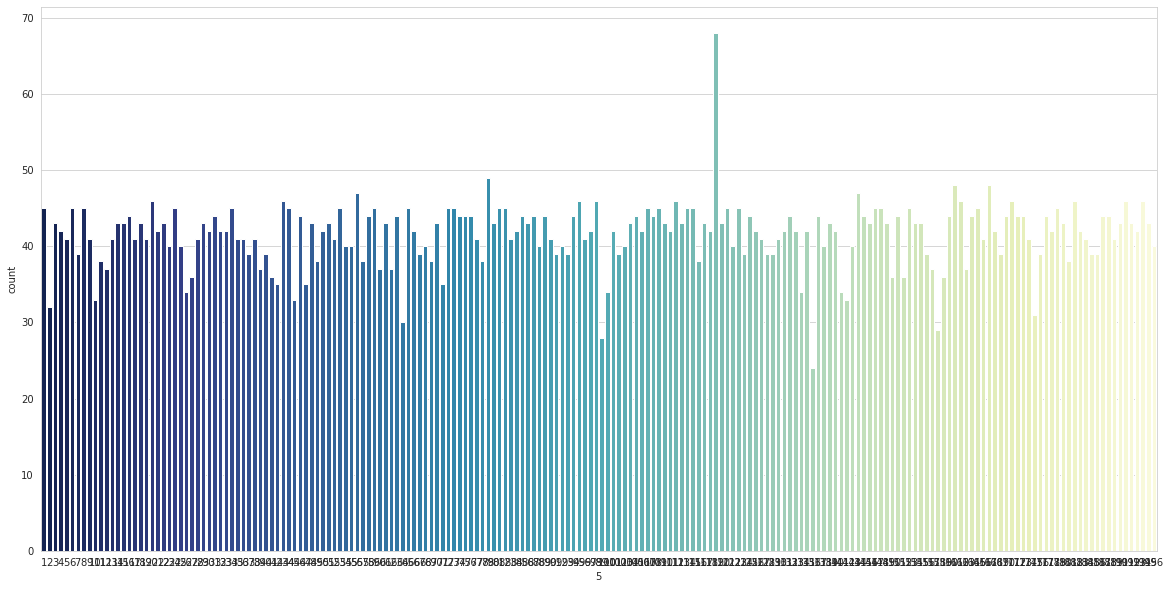

In [73]:
sns.set_style('whitegrid')
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x=5,data=annotation_train_csv, palette='YlGnBu_r')
plt.show()

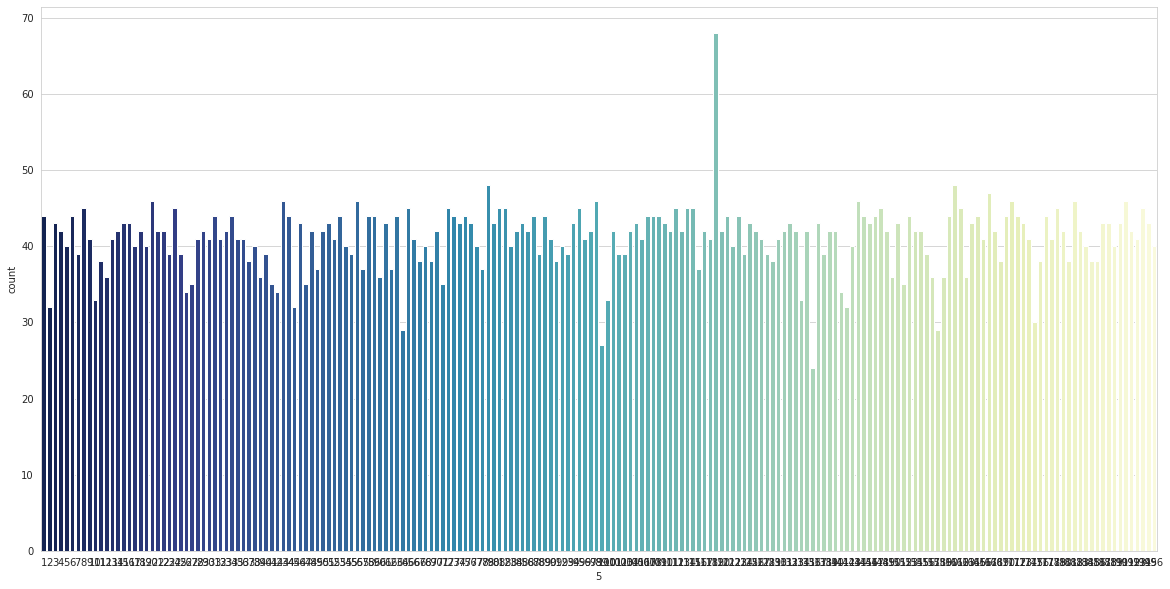

In [74]:
sns.set_style('whitegrid')
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x=5,data=annotation_test_csv, palette='YlGnBu_r')
plt.show()

## Both Train and Test data classes are almost distributed with the same number of samples for each class of vehicle . Though the range of samples for each vehicle range is form 25-75 images .

car_data/car_data/train/Acura TL Sedan 2012/00002.jpg
[[car_data/car_data/train/Acura TL Sedan 2012/00002.jpg
  'car_data/car_data/train/Acura TL Sedan 2012' '00002.jpg']]
137    car_data/car_data/train/Acura TL Sedan 2012/00...
Name: 0, dtype: object
                                                     0  ...          2
137  car_data/car_data/train/Acura TL Sedan 2012/00...  ...  00002.jpg

[1 rows x 3 columns]


SystemError: ignored

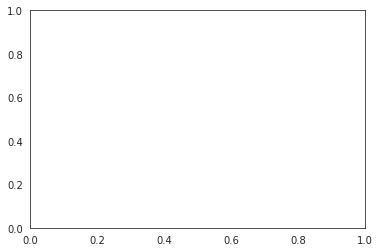

In [106]:
sns.set_style('white')
loadImage = [1,10,96,25,80,100,130,500,1000,5000,8000]
 
def load_image_boundary(imgData,metaDF):
    sns.set_style('white')
    for i in loadImage:
      fig,ax = plt.subplots(1)
      print(imgData[10][i])
      print(metaDF.loc[metaDF[0] == imgData[10][i]].values)
      print(metaDF.loc[metaDF[0] == imgData[10][i]][0])
      image = load_image(metaDF.loc[metaDF[0] == imgData[10][i]])
      print ("Size of original input: ", image.shape)
      print ("Path of original input: ", imgData[10][i])
      print ("File of original input: ", imgData[0][i])
      fig.suptitle(f'Name is {imgData[9][i]}')
      ax.imshow(image)
      print("Class Variable of the Input:",imgData[7][i])
      #print(type(imagepoints))
      x0 = int(imgData[1][i])
      x1 = int(imgData[3][i])
      y0 = int(imgData[2][i])
      y1 = int(imgData[4][i])
      rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)   
      plt.show()
load_image_boundary(train_data,trainMetaDataDF)
load_image_boundary(test_data)

car_data/car_data/train/AM General Hummer SUV 2000/06174.jpg
Size of original input:  (179, 300, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/06174.jpg
File of original input:  06174.jpg
0    06174.jpg
1            1
2            1
3          300
4          179
5            1
Name: 6173, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


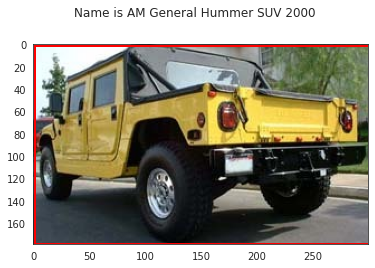

car_data/car_data/train/AM General Hummer SUV 2000/05754.jpg
Size of original input:  (96, 96, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/05754.jpg
File of original input:  05754.jpg
0    05754.jpg
1            4
2            9
3           96
4           88
5            1
Name: 5753, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


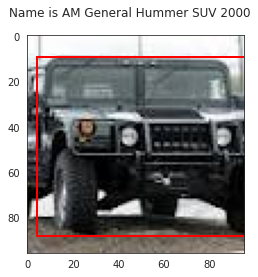

car_data/car_data/train/Acura RL Sedan 2012/07897.jpg
Size of original input:  (420, 628, 3)
Path of original input:  car_data/car_data/train/Acura RL Sedan 2012/07897.jpg
File of original input:  07897.jpg
0    07897.jpg
1           18
2          141
3          603
4          367
5            2
Name: 7896, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']


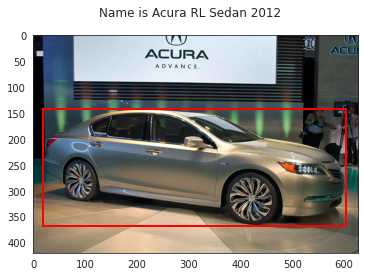

car_data/car_data/train/AM General Hummer SUV 2000/04578.jpg
Size of original input:  (334, 500, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/04578.jpg
File of original input:  04578.jpg
0    04578.jpg
1           21
2           18
3          492
4          316
5            1
Name: 4577, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


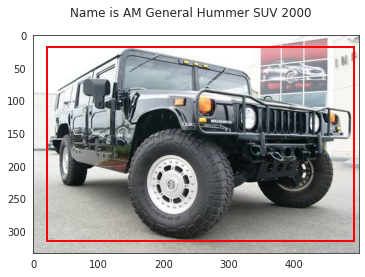

car_data/car_data/train/Acura Integra Type R 2001/03670.jpg
Size of original input:  (326, 500, 3)
Path of original input:  car_data/car_data/train/Acura Integra Type R 2001/03670.jpg
File of original input:  03670.jpg
0    03670.jpg
1          146
2           73
3          486
4          236
5            6
Name: 3669, dtype: object
Class Variable of the Input: ['Acura Integra Type R 2001']


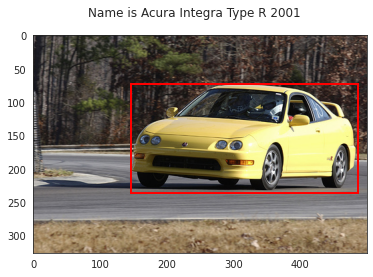

car_data/car_data/train/Acura RL Sedan 2012/02669.jpg
Size of original input:  (600, 800, 3)
Path of original input:  car_data/car_data/train/Acura RL Sedan 2012/02669.jpg
File of original input:  02669.jpg
0    02669.jpg
1           13
2          256
3          769
4          532
5            2
Name: 2668, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']


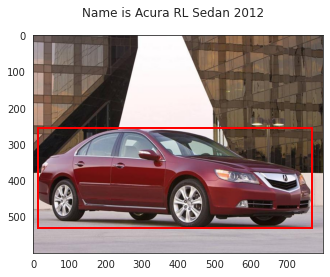

car_data/car_data/train/Acura TL Sedan 2012/00740.jpg
Size of original input:  (389, 632, 3)
Path of original input:  car_data/car_data/train/Acura TL Sedan 2012/00740.jpg
File of original input:  00740.jpg
0    00740.jpg
1           37
2           77
3          582
4          342
5            3
Name: 739, dtype: object
Class Variable of the Input: ['Acura TL Sedan 2012']


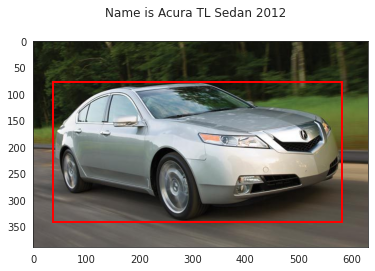

car_data/car_data/train/Audi 100 Wagon 1994/03435.jpg
Size of original input:  (66, 89, 3)
Path of original input:  car_data/car_data/train/Audi 100 Wagon 1994/03435.jpg
File of original input:  03435.jpg
0    03435.jpg
1            4
2           15
3           87
4           54
5           18
Name: 3434, dtype: object
Class Variable of the Input: ['Audi 100 Wagon 1994']


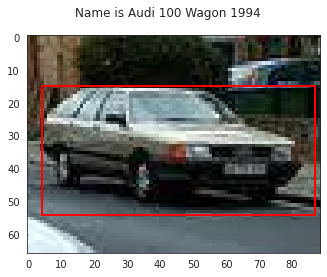

car_data/car_data/train/Audi V8 Sedan 1994/02728.jpg
Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/train/Audi V8 Sedan 1994/02728.jpg
File of original input:  02728.jpg
0    02728.jpg
1            5
2           73
3          280
4          221
5           16
Name: 2727, dtype: object
Class Variable of the Input: ['Audi V8 Sedan 1994']


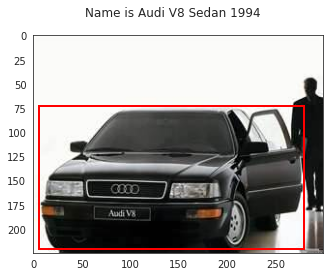

car_data/car_data/train/GMC Terrain SUV 2012/04666.jpg
Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/train/GMC Terrain SUV 2012/04666.jpg
File of original input:  04666.jpg
0    04666.jpg
1           10
2           37
3          284
4          157
5          118
Name: 4665, dtype: object
Class Variable of the Input: ['GMC Terrain SUV 2012']


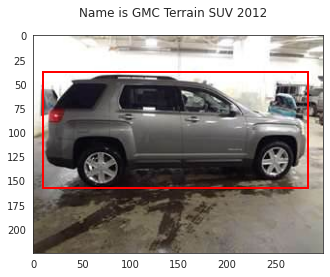

car_data/car_data/train/Volvo 240 Sedan 1993/01844.jpg
Size of original input:  (480, 640, 3)
Path of original input:  car_data/car_data/train/Volvo 240 Sedan 1993/01844.jpg
File of original input:  01844.jpg
0    01844.jpg
1           33
2          176
3          608
4          468
5          194
Name: 1843, dtype: object
Class Variable of the Input: ['Volvo 240 Sedan 1993']


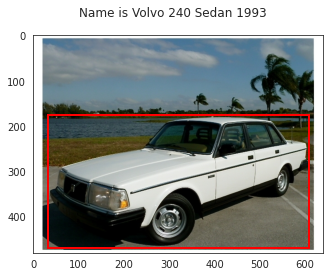

car_data/car_data/test/AM General Hummer SUV 2000/00457.jpg
Size of original input:  (144, 250, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/00457.jpg
File of original input:  00457.jpg
0    00457.jpg
1           31
2           20
3          226
4          119
5            1
Name: 456, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


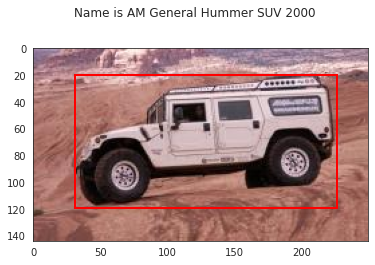

car_data/car_data/test/AM General Hummer SUV 2000/01167.jpg
Size of original input:  (182, 278, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/01167.jpg
File of original input:  01167.jpg
0    01167.jpg
1           14
2           16
3          268
4          169
5            1
Name: 1166, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


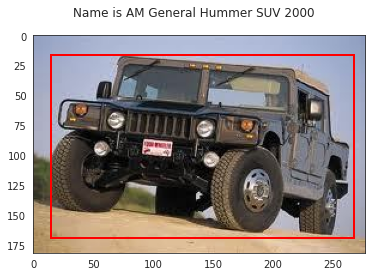

car_data/car_data/test/Acura RL Sedan 2012/00580.jpg
Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/test/Acura RL Sedan 2012/00580.jpg
File of original input:  00580.jpg
0    00580.jpg
1            2
2          104
3          300
4          203
5            2
Name: 579, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']


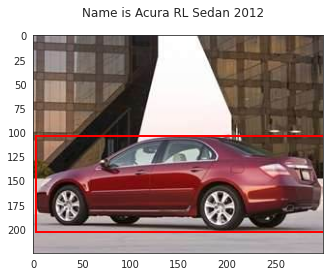

car_data/car_data/test/AM General Hummer SUV 2000/03094.jpg
Size of original input:  (437, 600, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/03094.jpg
File of original input:  03094.jpg
0    03094.jpg
1           53
2          108
3          544
4          413
5            1
Name: 3093, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']


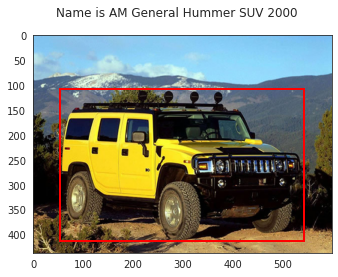

car_data/car_data/test/Acura Integra Type R 2001/06031.jpg
Size of original input:  (480, 640, 3)
Path of original input:  car_data/car_data/test/Acura Integra Type R 2001/06031.jpg
File of original input:  06031.jpg
0    06031.jpg
1           17
2          108
3          624
4          431
5            6
Name: 6030, dtype: object
Class Variable of the Input: ['Acura Integra Type R 2001']


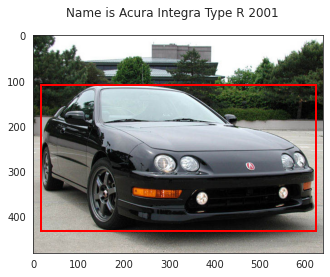

car_data/car_data/test/Acura RL Sedan 2012/04311.jpg
Size of original input:  (347, 960, 3)
Path of original input:  car_data/car_data/test/Acura RL Sedan 2012/04311.jpg
File of original input:  04311.jpg
0    04311.jpg
1           97
2            7
3          888
4          336
5            2
Name: 4310, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']


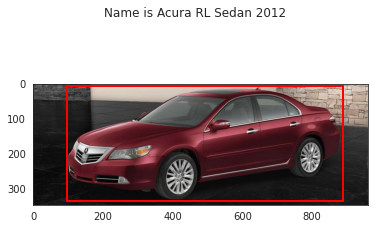

car_data/car_data/test/Acura TL Sedan 2012/01911.jpg
Size of original input:  (563, 800, 3)
Path of original input:  car_data/car_data/test/Acura TL Sedan 2012/01911.jpg
File of original input:  01911.jpg
0    01911.jpg
1          121
2          133
3          674
4          544
5            3
Name: 1910, dtype: object
Class Variable of the Input: ['Acura TL Sedan 2012']


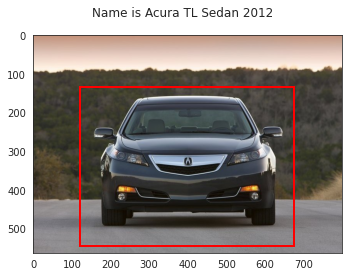

car_data/car_data/test/Audi 100 Wagon 1994/02301.jpg
Size of original input:  (219, 300, 3)
Path of original input:  car_data/car_data/test/Audi 100 Wagon 1994/02301.jpg
File of original input:  02301.jpg
0    02301.jpg
1           24
2           69
3          283
4          164
5           18
Name: 2300, dtype: object
Class Variable of the Input: ['Audi 100 Wagon 1994']


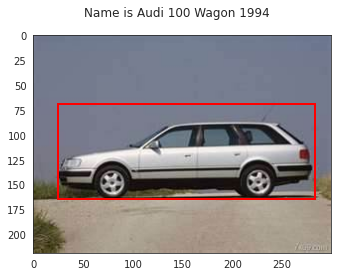

car_data/car_data/test/Audi V8 Sedan 1994/01858.jpg
Size of original input:  (469, 625, 3)
Path of original input:  car_data/car_data/test/Audi V8 Sedan 1994/01858.jpg
File of original input:  01858.jpg
0    01858.jpg
1           37
2          124
3          560
4          341
5           16
Name: 1857, dtype: object
Class Variable of the Input: ['Audi V8 Sedan 1994']


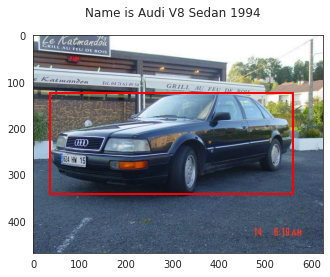

car_data/car_data/test/GMC Yukon Hybrid SUV 2012/00367.jpg
Size of original input:  (600, 800, 3)
Path of original input:  car_data/car_data/test/GMC Yukon Hybrid SUV 2012/00367.jpg
File of original input:  00367.jpg
0    00367.jpg
1           13
2          114
3          790
4          487
5          120
Name: 366, dtype: object
Class Variable of the Input: ['GMC Yukon Hybrid SUV 2012']


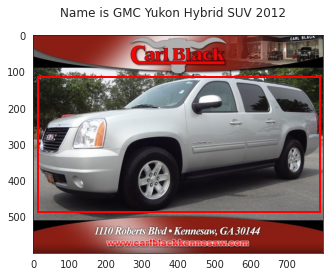

car_data/car_data/test/Volvo XC90 SUV 2007/02127.jpg
Size of original input:  (375, 500, 3)
Path of original input:  car_data/car_data/test/Volvo XC90 SUV 2007/02127.jpg
File of original input:  02127.jpg
0    02127.jpg
1            8
2           61
3          456
4          371
5          195
Name: 2126, dtype: object
Class Variable of the Input: ['Volvo XC90 SUV 2007']


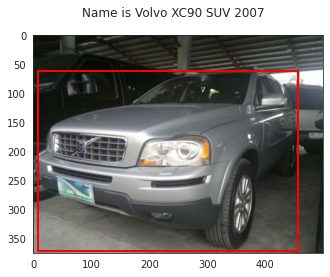

In [107]:
sns.set_style('white')
loadImage = [1,10,96,25,80,100,130,500,1000,5000,8000]
 
def load_image_boundary(metaData,annotation):
    sns.set_style('white')
    for i in loadImage:
      fig,ax = plt.subplots(1)
      image = load_image(metaData[i].image_path())
      print ("Size of original input: ", image.shape)
      print ("Path of original input: ", metaData[i].image_path())
      print ("File of original input: ", metaData[i].file)
      fig.suptitle(f'Name is {metaData[i].name}')
      ax.imshow(image)
      refImg = metaData[i].file.split(".")
      #print(refImg)
      imagepoints = annotation.iloc[int(refImg[0])-1]
      print(imagepoints)
      print("Class Variable of the Input:",data_labels[imagepoints[5]-1])
      #print(type(imagepoints))
      x0 = int(imagepoints[1])
      x1 = int(imagepoints[3])
      y0 = int(imagepoints[2])
      y1 = int(imagepoints[4])
      rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)   
      plt.show()

load_image_boundary(trainMetaData,annotation_train_csv)
load_image_boundary(testMetaData,annotation_test_csv)


# Pre-Processing

Size of original input:  (179, 300, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/06174.jpg
File of original input:  06174.jpg
0    06174.jpg
1            1
2            1
3          300
4          179
5            1
Name: 6173, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
0 224 1 224


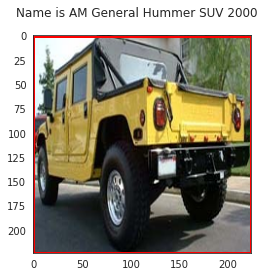

Size of original input:  (96, 96, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/05754.jpg
File of original input:  05754.jpg
0    05754.jpg
1            4
2            9
3           96
4           88
5            1
Name: 5753, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
9 224 21 205


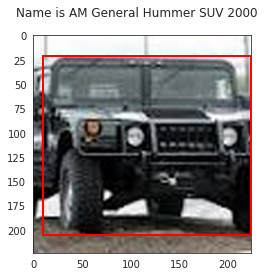

Size of original input:  (420, 628, 3)
Path of original input:  car_data/car_data/train/Acura RL Sedan 2012/07897.jpg
File of original input:  07897.jpg
0    07897.jpg
1           18
2          141
3          603
4          367
5            2
Name: 7896, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']
6 215 75 195


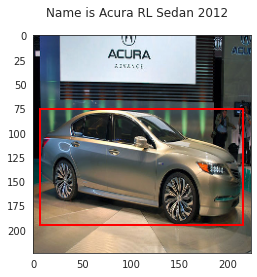

Size of original input:  (334, 500, 3)
Path of original input:  car_data/car_data/train/AM General Hummer SUV 2000/04578.jpg
File of original input:  04578.jpg
0    04578.jpg
1           21
2           18
3          492
4          316
5            1
Name: 4577, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
9 220 12 211


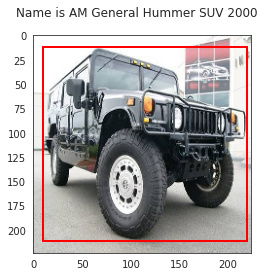

Size of original input:  (326, 500, 3)
Path of original input:  car_data/car_data/train/Acura Integra Type R 2001/03670.jpg
File of original input:  03670.jpg
0    03670.jpg
1          146
2           73
3          486
4          236
5            6
Name: 3669, dtype: object
Class Variable of the Input: ['Acura Integra Type R 2001']
65 217 50 162


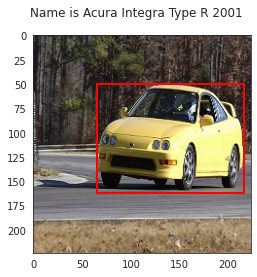

Size of original input:  (600, 800, 3)
Path of original input:  car_data/car_data/train/Acura RL Sedan 2012/02669.jpg
File of original input:  02669.jpg
0    02669.jpg
1           13
2          256
3          769
4          532
5            2
Name: 2668, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']
3 215 95 198


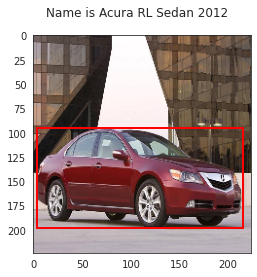

Size of original input:  (389, 632, 3)
Path of original input:  car_data/car_data/train/Acura TL Sedan 2012/00740.jpg
File of original input:  00740.jpg
0    00740.jpg
1           37
2           77
3          582
4          342
5            3
Name: 739, dtype: object
Class Variable of the Input: ['Acura TL Sedan 2012']
13 206 44 196


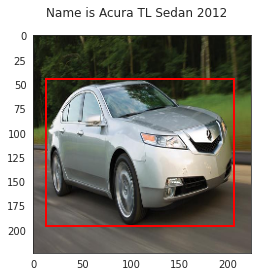

Size of original input:  (66, 89, 3)
Path of original input:  car_data/car_data/train/Audi 100 Wagon 1994/03435.jpg
File of original input:  03435.jpg
0    03435.jpg
1            4
2           15
3           87
4           54
5           18
Name: 3434, dtype: object
Class Variable of the Input: ['Audi 100 Wagon 1994']
10 218 50 183


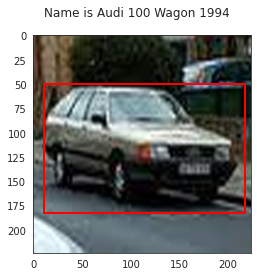

Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/train/Audi V8 Sedan 1994/02728.jpg
File of original input:  02728.jpg
0    02728.jpg
1            5
2           73
3          280
4          221
5           16
Name: 2727, dtype: object
Class Variable of the Input: ['Audi V8 Sedan 1994']
3 209 72 220


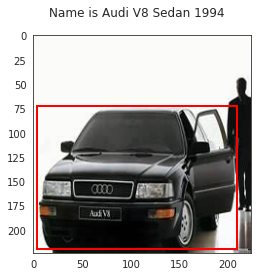

Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/train/GMC Terrain SUV 2012/04666.jpg
File of original input:  04666.jpg
0    04666.jpg
1           10
2           37
3          284
4          157
5          118
Name: 4665, dtype: object
Class Variable of the Input: ['GMC Terrain SUV 2012']
7 212 36 156


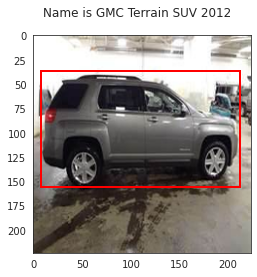

Size of original input:  (480, 640, 3)
Path of original input:  car_data/car_data/train/Volvo 240 Sedan 1993/01844.jpg
File of original input:  01844.jpg
0    01844.jpg
1           33
2          176
3          608
4          468
5          194
Name: 1843, dtype: object
Class Variable of the Input: ['Volvo 240 Sedan 1993']
11 212 82 218


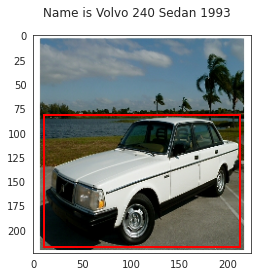

Size of original input:  (144, 250, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/00457.jpg
File of original input:  00457.jpg
0    00457.jpg
1           31
2           20
3          226
4          119
5            1
Name: 456, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
27 202 31 185


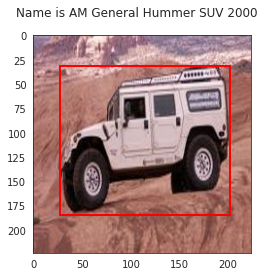

Size of original input:  (182, 278, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/01167.jpg
File of original input:  01167.jpg
0    01167.jpg
1           14
2           16
3          268
4          169
5            1
Name: 1166, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
11 215 19 208


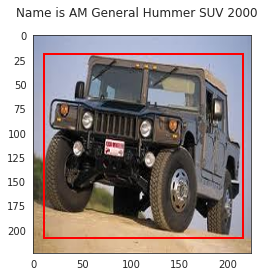

Size of original input:  (225, 300, 3)
Path of original input:  car_data/car_data/test/Acura RL Sedan 2012/00580.jpg
File of original input:  00580.jpg
0    00580.jpg
1            2
2          104
3          300
4          203
5            2
Name: 579, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']
1 224 103 202


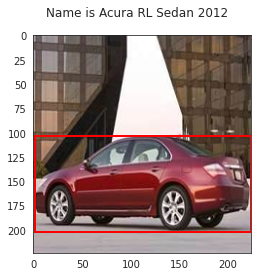

Size of original input:  (437, 600, 3)
Path of original input:  car_data/car_data/test/AM General Hummer SUV 2000/03094.jpg
File of original input:  03094.jpg
0    03094.jpg
1           53
2          108
3          544
4          413
5            1
Name: 3093, dtype: object
Class Variable of the Input: ['AM General Hummer SUV 2000']
19 203 55 211


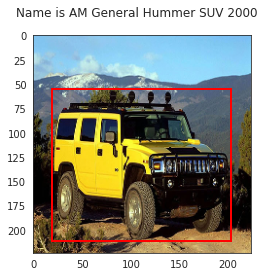

Size of original input:  (480, 640, 3)
Path of original input:  car_data/car_data/test/Acura Integra Type R 2001/06031.jpg
File of original input:  06031.jpg
0    06031.jpg
1           17
2          108
3          624
4          431
5            6
Name: 6030, dtype: object
Class Variable of the Input: ['Acura Integra Type R 2001']
5 218 50 201


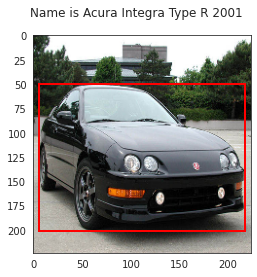

Size of original input:  (347, 960, 3)
Path of original input:  car_data/car_data/test/Acura RL Sedan 2012/04311.jpg
File of original input:  04311.jpg
0    04311.jpg
1           97
2            7
3          888
4          336
5            2
Name: 4310, dtype: object
Class Variable of the Input: ['Acura RL Sedan 2012']
22 207 4 216


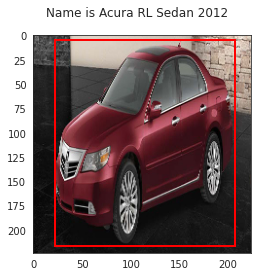

Size of original input:  (563, 800, 3)
Path of original input:  car_data/car_data/test/Acura TL Sedan 2012/01911.jpg
File of original input:  01911.jpg
0    01911.jpg
1          121
2          133
3          674
4          544
5            3
Name: 1910, dtype: object
Class Variable of the Input: ['Acura TL Sedan 2012']
33 188 52 216


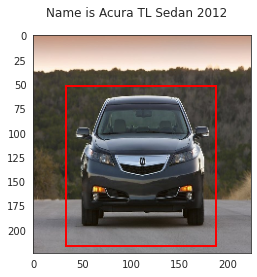

Size of original input:  (219, 300, 3)
Path of original input:  car_data/car_data/test/Audi 100 Wagon 1994/02301.jpg
File of original input:  02301.jpg
0    02301.jpg
1           24
2           69
3          283
4          164
5           18
Name: 2300, dtype: object
Class Variable of the Input: ['Audi 100 Wagon 1994']
17 211 70 167


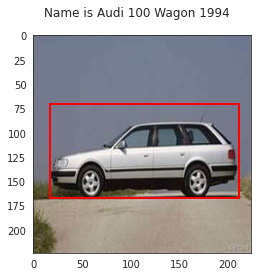

Size of original input:  (469, 625, 3)
Path of original input:  car_data/car_data/test/Audi V8 Sedan 1994/01858.jpg
File of original input:  01858.jpg
0    01858.jpg
1           37
2          124
3          560
4          341
5           16
Name: 1857, dtype: object
Class Variable of the Input: ['Audi V8 Sedan 1994']
13 200 59 162


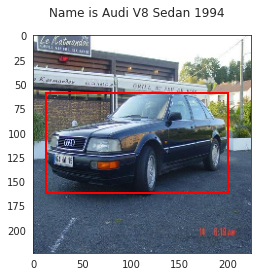

Size of original input:  (600, 800, 3)
Path of original input:  car_data/car_data/test/GMC Yukon Hybrid SUV 2012/00367.jpg
File of original input:  00367.jpg
0    00367.jpg
1           13
2          114
3          790
4          487
5          120
Name: 366, dtype: object
Class Variable of the Input: ['GMC Yukon Hybrid SUV 2012']
3 221 42 181


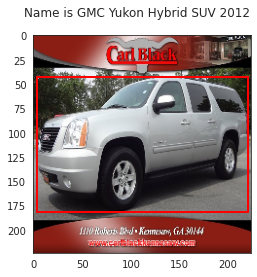

Size of original input:  (375, 500, 3)
Path of original input:  car_data/car_data/test/Volvo XC90 SUV 2007/02127.jpg
File of original input:  02127.jpg
0    02127.jpg
1            8
2           61
3          456
4          371
5          195
Name: 2126, dtype: object
Class Variable of the Input: ['Volvo XC90 SUV 2007']
3 204 36 221


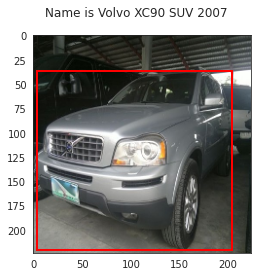

In [14]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def load_image_boundary_standard_size(metaData,annotation):
    sns.set_style('white')
    for i in loadImage:
      fig,ax = plt.subplots(1)
      image = load_image(metaData[i].image_path())
      print ("Size of original input: ", image.shape)
      print ("Path of original input: ", metaData[i].image_path())
      print ("File of original input: ", metaData[i].file)
      image_height, image_width, _ = image.shape
      image = cv2.resize(image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
      fig.suptitle(f'Name is {metaData[i].name}')
      ax.imshow(image)
      refImg = metaData[i].file.split(".")
      #print(refImg)
      imagepoints = annotation.iloc[int(refImg[0])-1]
      print(imagepoints)
      print("Class Variable of the Input:",data_labels[imagepoints[5]-1])
      #print(type(imagepoints))
      x0 = int(imagepoints[1]* IMAGE_WIDTH / image_width)
      x1 = int(imagepoints[3]* IMAGE_WIDTH / image_width)
      y0 = int(imagepoints[2]* IMAGE_HEIGHT / image_height)
      y1 = int(imagepoints[4]* IMAGE_HEIGHT / image_height)
      print(x0,x1,y0,y1)
      rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)   
      plt.show()

load_image_boundary_standard_size(trainMetaData,annotation_train_csv)
load_image_boundary_standard_size(testMetaData,annotation_test_csv)


Augmented:


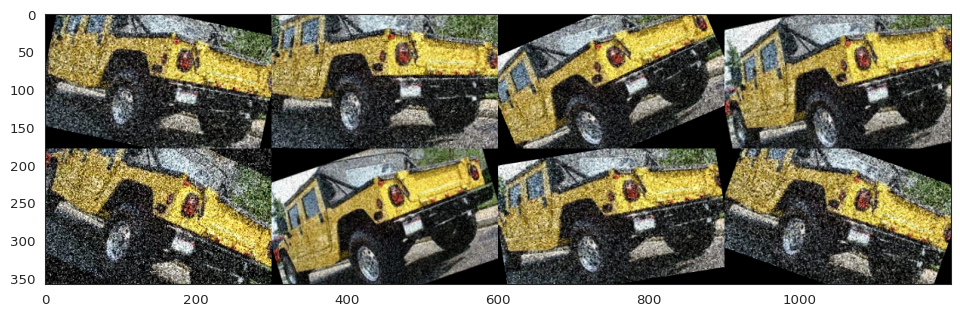

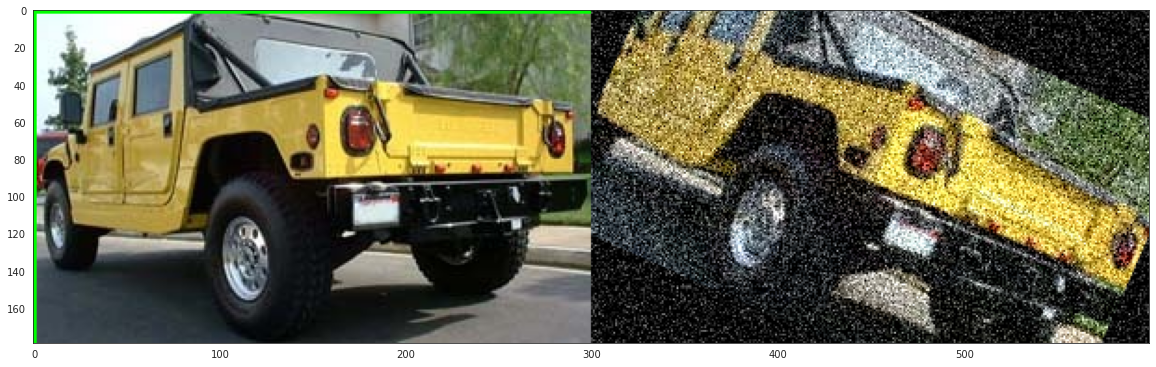

In [17]:
image1 = load_image(trainMetaData[1].image_path())
refImgPoint = trainMetaData[1].file.split(".")
imagepoints = annotation_train_csv.iloc[int(refImgPoint[0])-1]
bbsoi = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=imagepoints[1], y1=imagepoints[2], x2=imagepoints[3], y2=imagepoints[4])
], shape=image1.shape)
bbs = [ia.BoundingBox(x1=imagepoints[1], y1=imagepoints[2], x2=imagepoints[3], y2=imagepoints[4])]

seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(30, 90)),
    iaa.Crop(percent=(0, 0.1))
], random_order=True)

images_1_aug = [seq(image=image1) for _ in range(8)]
images_aug, bbs_aug = seq(image=image1,bounding_boxes=bbsoi)
print("Augmented:")
ia.imshow(ia.draw_grid(images_1_aug, cols=4, rows=2))
# visualize
side_by_side = np.hstack([
    bbsoi.draw_on_image(image1, size=2),
    bbs_aug.draw_on_image(images_aug, size=2)
])
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(side_by_side)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('car_data/car_data/train/',
                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


## Size of the Images are different